# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Python Installation**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Modern Portfolio Theory on Multiple Assets
In this notebook, we provide a model solution to implement the Modern Portfolio Theorem (MPT) on multiple assets. You can refer to this if you are stuck in any step while building your capstone project solution. The model solution here guides you to answer the problem statements posed in the capstone project. The notebook structure is as follows:

1. [Import the data and calculate annualised returns](#data): You already know this from the MPT notebook on two assets.

1. [Make random portfolios with different weights](#weights): Create a portfolio with random weights of the constituents. The portfolio metrics is calculated and saved in a data frame.

1. [Identify the portfolios with maximum returns/risk and minimum risk](#max): The portfolios with minimum risk and maximum Sharpe ratio (returns/risk) is selected from the list of random portfolios.

1. [Efficient frontier](#frontier): The efficient frontier is plotted for a visual representation of the various portfolios.

1. [Results](#opt_wt): The optimal weights are printed for the portfolios with minimum risk and maximum Sharpe ratio.

In [1]:
# Importing the necessary Python modules required in this notebook 
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

<a id='data'></a> 
## Import the data and calculate annualised returns
We have imported and saved the prices of the stocks, Chevron (CVX), Microsoft (MSFT) and Google (GOOGL) in a CSV file. You will read the CSV file and save in a dataframe.

You can use your own data file with more assets coming in as additional columns.

In [2]:
# Read CSV to get the prices
stock_prices_1 = pd.read_csv("stock.csv",index_col=0)


stock_prices_1 = stock_prices_1.pivot_table(index=['Date'],columns=['ticker'],values=['Close']).rename_axis(None, axis=0)
stock_prices_1.columns = stock_prices_1.columns.droplevel(0)


stock_prices = stock_prices_1.drop(['GDX','XME','XOP'],axis=1)
#2017-01-03 to 2020-02-03
#period = (stock_prices_1[1] > '2017-01-03') & (stock_prices_1[1] <= '2017-01-03')
stock_prices

ticker,IYR,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
2000-07-03,35.578125,20.187500,30.531250,19.648661,28.656250,54.562500,25.281250,28.062500,29.500000,25.937500
2000-07-05,35.906250,20.281250,29.265625,19.864439,28.406250,52.812500,25.343750,28.312500,29.687500,26.250000
2000-07-06,36.015625,19.750000,29.562500,20.016754,28.328125,53.625000,25.375000,28.343750,29.625000,26.437500
2000-07-07,36.281250,19.656250,29.703125,20.359465,28.468750,54.500000,25.203125,28.640625,29.875000,27.718750
2000-07-10,36.250000,19.937500,29.843750,20.410236,28.500000,53.906250,25.437500,28.640625,29.625000,28.125000
...,...,...,...,...,...,...,...,...,...,...
2022-02-03,106.110001,84.519997,67.839996,39.430000,101.199997,158.960007,76.830002,69.029999,132.779999,179.300003
2022-02-04,105.129997,83.120003,68.900002,40.099998,100.110001,159.600006,75.889999,68.480003,132.300003,184.399994
2022-02-07,104.949997,82.709999,69.779999,40.220001,100.190002,158.539993,76.029999,68.379997,132.070007,184.020004
2022-02-08,104.400002,83.989998,68.279999,40.779999,101.190002,160.500000,76.320000,68.430000,133.149994,186.610001


In [3]:

# Calculate annualised returns
annual_returns = ((((stock_prices.iloc[-1]-stock_prices.iloc[0]) / stock_prices.iloc[0]) \
                   + 1)**(252/len(stock_prices)) - 1)
annual_returns

ticker
IYR    0.052264
XLB    0.069377
XLE    0.038409
XLF    0.034727
XLI    0.060889
XLK    0.052349
XLP    0.052556
XLU    0.042391
XLV    0.072733
XLY    0.096443
dtype: float64

<a id='weights'></a> 
## Make random portfolios with different weights

Let's generate 1000 portfolios with different percentage of allocations for the constituents. You will calculate portfolio returns and portfolio standard deviation for all the portfolios and save it into the dataframe `portfolio`. The weight allocation is saved in the list named `weights_array`.

The number 1000 is just for an example here and can be increased if you want.

In [4]:
# Create an empty dataframe
portfolio = pd.DataFrame()
weights_array = []

# Initialize the number of portfolios
num_of_portfolios = 1000

# Get the number of stocks available in the data file
num_of_stocks = stock_prices.shape[1]

# Calculate daily returns
stock_returns = stock_prices.pct_change().dropna()

# Run the loop for each portfolio
for i in range(num_of_portfolios):
    # Generate random portfolio
    rnd_nums = list(np.random.random(num_of_stocks))
    
    # Ensure the sum of weights is 1
    weights = list(rnd_nums/sum(rnd_nums))
    
    # Save weight allocation in a list
    weights_array.append(weights)
    
    # Save the portfolio returns and portfolio standard deviation values along with its ratio
    portfolio.loc[i, 'returns'] = sum(weights * annual_returns)
    
    # Calculate the portfolio returns
    portfolio_rets = stock_returns * weights
    
    # Caclulate the portfolio standard deviation
    portfolio.loc[i, 'std_dev'] = portfolio_rets.sum(axis=1).std()*math.sqrt(252)

    # Caclulate the portfolio Sharpe 
    portfolio.loc[i, 'returns/std_dev'] = portfolio.loc[i, 'returns'] / portfolio.loc[i, 'std_dev']

<a id='max'></a> 
## Identify the portfolios with maximum returns/risk and minimum risk

Let's identify the portfolio with maximum returns/standard deviation. We will also identify the portfolio with the minimum standard deviation.

In [5]:
# Identify the portfolio with the maximum returns/standard deviation using idxmax() function
max_ret_by_std_dev = portfolio.iloc[portfolio['returns/std_dev'].idxmax()]
wts_max_ret_by_std_dev = weights_array[portfolio['returns/std_dev'].idxmax()]

# Similarly identify the portfolio with the minimum standard deviation using idxmin() function
min_std_dev = portfolio.iloc[portfolio['std_dev'].idxmin()]
wts_min_std_dev = weights_array[portfolio['std_dev'].idxmin()]

<a id='frontier'></a>
## Efficient frontier

We will plot all the 1000 portfolios in a graph with portfolio standard deviation on the X-axis and portfolio returns on the Y-axis. The curve generated is known as the <b>Efficient Frontier</b>

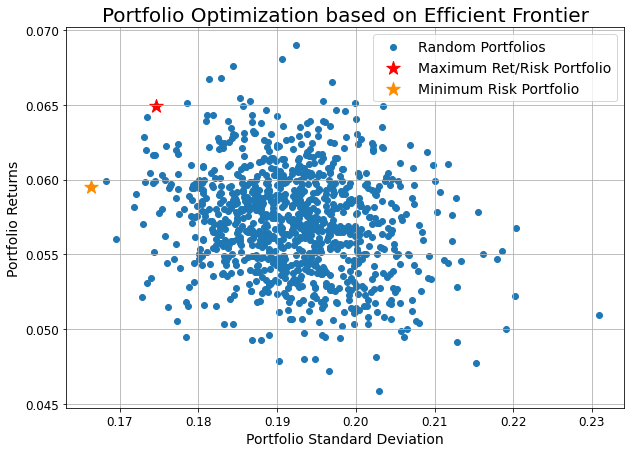

In [6]:
# Highlight the maximum returns/risk portfolio and minimum risk portfolio
plt.figure(figsize=(10, 7))
plt.grid()
plt.scatter(portfolio.std_dev, portfolio.returns, label='Random Portfolios')
plt.scatter(max_ret_by_std_dev.std_dev, max_ret_by_std_dev.returns,
            marker='*', s=200, color='r', label='Maximum Ret/Risk Portfolio')
plt.scatter(min_std_dev.std_dev, min_std_dev.returns,
            marker='*', s=200, color='darkorange', label='Minimum Risk Portfolio')
plt.xlabel('Portfolio Standard Deviation', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Portfolio Returns', fontsize=14)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=14)
plt.title('Portfolio Optimization based on Efficient Frontier', fontsize=20)
plt.show()

<a id='opt_wt'></a> 
## Results

You have saved the weights also while creating the portfolios. You can now get the optimal weights of the portfolio with maximum returns/standard deviation value.

### Portfolio with maximum Sharpe ratio (returns/standard deviation)

In [7]:
# Print the portfolio with the maximum Sharpe ratio
print("The portfolio metrics for the maximum return/std dev. portfolio:")
print(max_ret_by_std_dev)
print("\nThe portfolio weights for each stock in the maximum return/std dev. portfolio is as:")
for i,j in zip(stock_prices.columns,wts_max_ret_by_std_dev):
    print("{} {}%".format(i,round(j*100,2))) 

The portfolio metrics for the maximum return/std dev. portfolio:
returns            0.064921
std_dev            0.174589
returns/std_dev    0.371850
Name: 822, dtype: float64

The portfolio weights for each stock in the maximum return/std dev. portfolio is as:
IYR 9.05%
XLB 5.64%
XLE 2.63%
XLF 0.59%
XLI 12.12%
XLK 8.21%
XLP 27.5%
XLU 6.29%
XLV 3.0%
XLY 24.98%


### Portfolio with minimum risk

In [8]:
# Print the portfolio with the minimum risk
print("The portfolio metrics for the minimum std dev. portfolio:")
print(min_std_dev)
print("\nThe portfolio weights for each stock in the minimum std dev. portfolio is as:")
for i,j in zip(stock_prices.columns,wts_min_std_dev):
    print("{} {}%".format(i,round(j*100,2))) 

The portfolio metrics for the minimum std dev. portfolio:
returns            0.059498
std_dev            0.166413
returns/std_dev    0.357532
Name: 241, dtype: float64

The portfolio weights for each stock in the minimum std dev. portfolio is as:
IYR 6.39%
XLB 7.77%
XLE 2.32%
XLF 1.4%
XLI 17.54%
XLK 0.91%
XLP 20.36%
XLU 19.17%
XLV 16.36%
XLY 7.79%


## Conclusion

The minimum risk portfolio assigns lesser weight to `MSFT` and more to `GOOGL`. The weight distribution is reversed in the portfolio with the maximum Sharpe ratio. This increase in weight of `MSFT` for the minimum risk porfolio indicates that `MSFT` is a safer investment for this data period. Similarly, `GOOGL` is a comparatively risky investment when compared to `MSFT`.

The MPT is thus implemented on multiple assets. You can try using this code on more stocks if you like with the additional assets coming in as additional columns.